In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [550]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")


plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [3]:
asf = dict({'C1s' : 0.296, 'O1s' : 0.711, 'N1s' : 0.477, 'Br3p' : 1.054, 'Br3d' : 1.054,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl2p' : 0.891, 'Si2p': 0.339})

## Pre-processing of data annealed APTES on ITO O3, plasma
1- Sample ZF594_PA1

# APTES data, ZF594_PA1

## Import raw data

In [204]:
path = '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = ['/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/Zoraida_Hank/20201124_ITO_clean.xy',
             '/Users/pabloherrero/sabat/xps_spectra/ITO_APTES/2021_04_27_qITO/20210427_ITO_APTES_thin.xy',
            '/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_28_qITO/20210428_3-qITO_clean.xy']

for f in files:
    files_new.append(f)

files = files_new
for f in files:
    print(os.path.split(f)[1])

20201124_ITO_clean.xy
20210427_ITO_APTES_thin.xy
20210428_3-qITO_clean.xy
20201202_ITO_DEA_ZTF594_PA1_rep.xy
20201203_ITO_DEA_ZTF594_PA1_Annealing.xy
20201207_ITO_DEA_ZTF594_PA15_Annealing.xy


In [5]:
experiments = import_group_xp(files[3])   # The function returns a list

In [205]:
aptes = [experiments[0], experiments[9], experiments[10]] + [xps_data_import(f) for f in files[:3]]

In [206]:
experiments[9].name


'annealing275'

In [207]:
names = ['vITO_APTES_RT', 'vITO-APTES_275ºC', 'vITO-APTES_300ºC', 'vITO_clean', 'qITO_APTES_RT', 'qITO_clean']
for xp, n in zip(aptes, names):
    xp.name = n

In [208]:
[xp.name for xp in aptes]

['vITO_APTES_RT',
 'vITO-APTES_275ºC',
 'vITO-APTES_300ºC',
 'vITO_clean',
 'qITO_APTES_RT',
 'qITO_clean']

## Align from In 3d

Text(0.5, 1.0, 'In 3d')

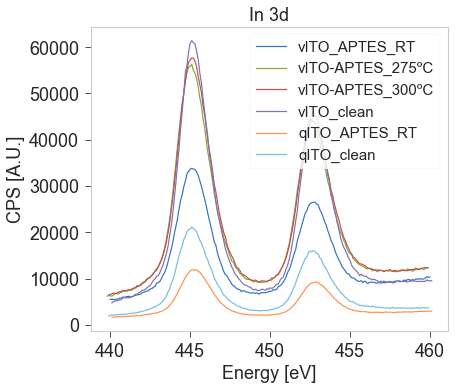

In [209]:
region = 'In3d'
aligned_exps = []

for xp in aptes:
    xp_new = crop_spectrum(xp, region=region, eup=None, edw=440)
    
    shift = find_shift(xp_new, xpRef=experiments[0], region=region)
    align_dfx(xp_new, shift, inplace = True)
    aligned_exps.append(xp_new)
    plot_region(xp_new, region)
plt.title('In 3d')

## Bg subtraction

### In 3d

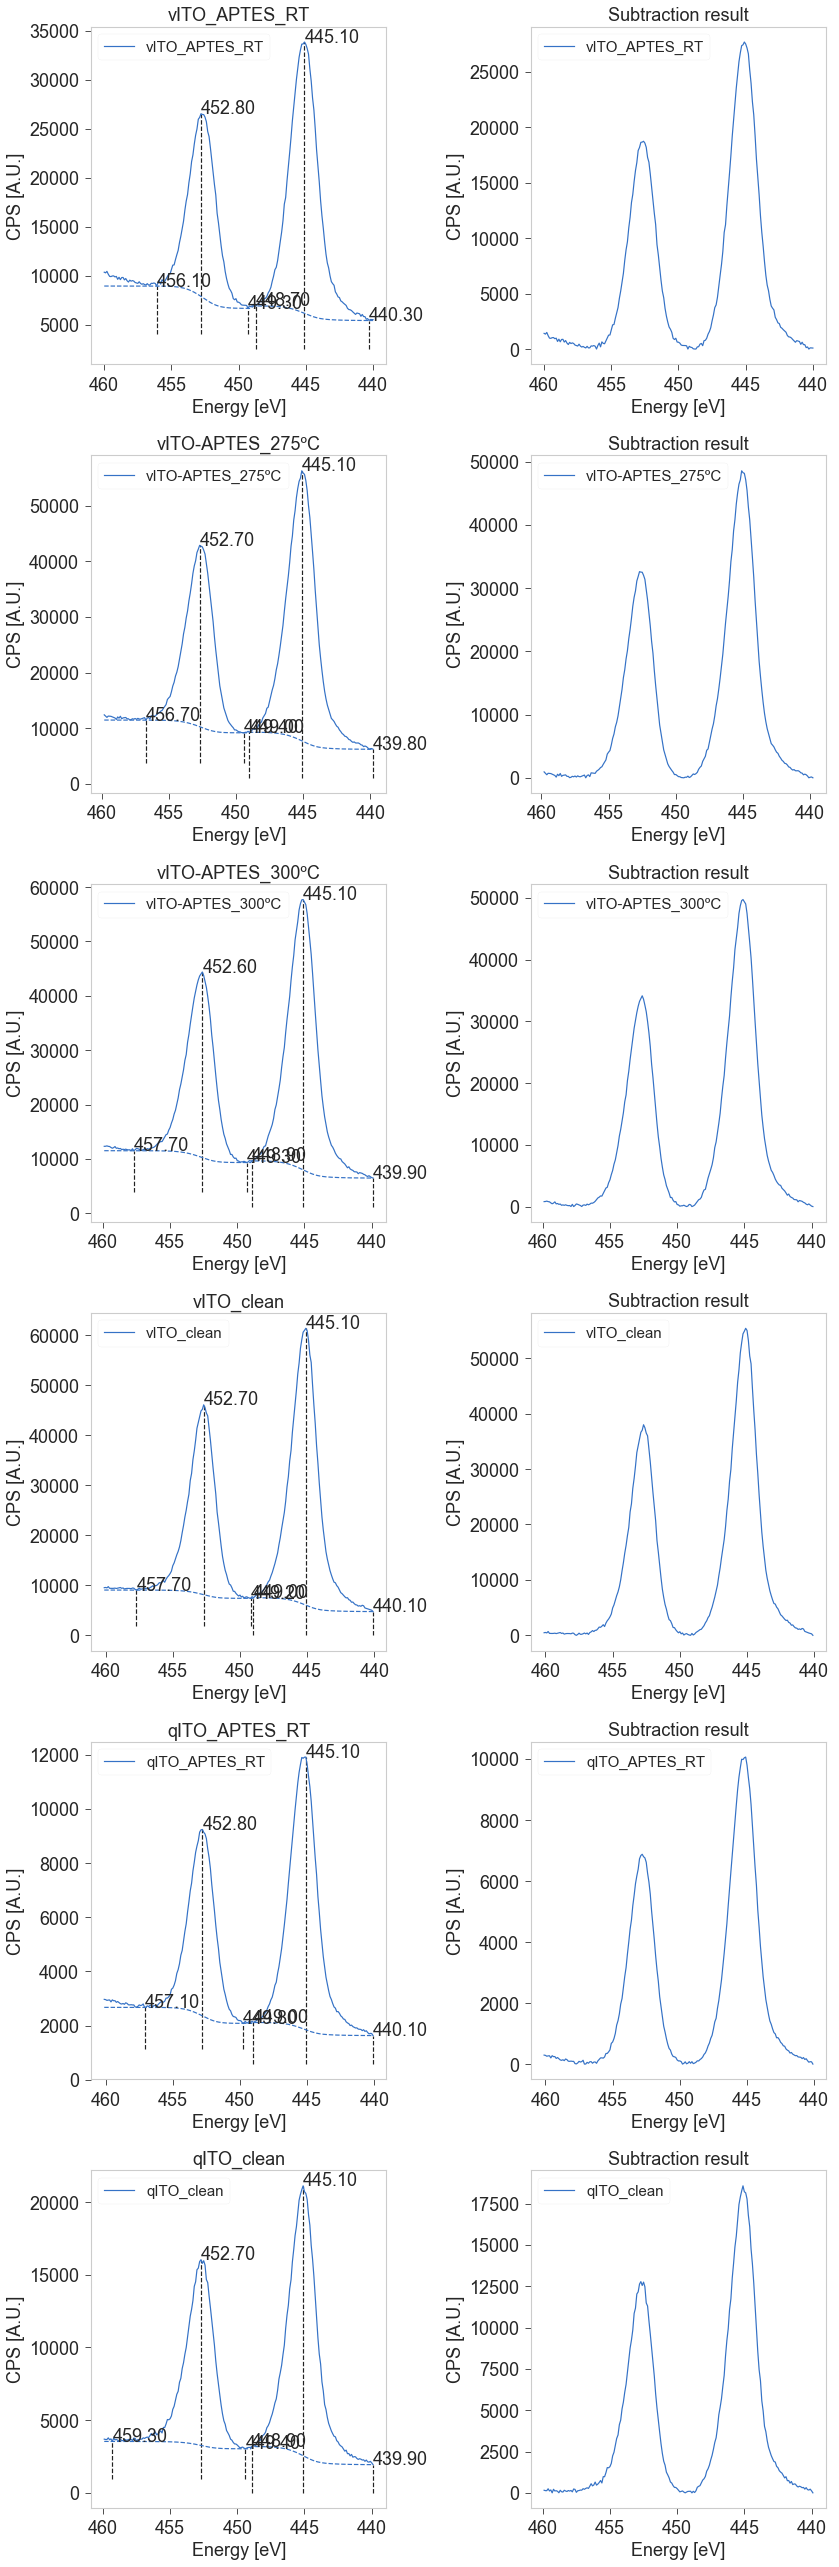

In [210]:
region = 'In3d'
bg_exps = region_2bg_subtract(aligned_exps, region, xlim=449)

### Sn 3d

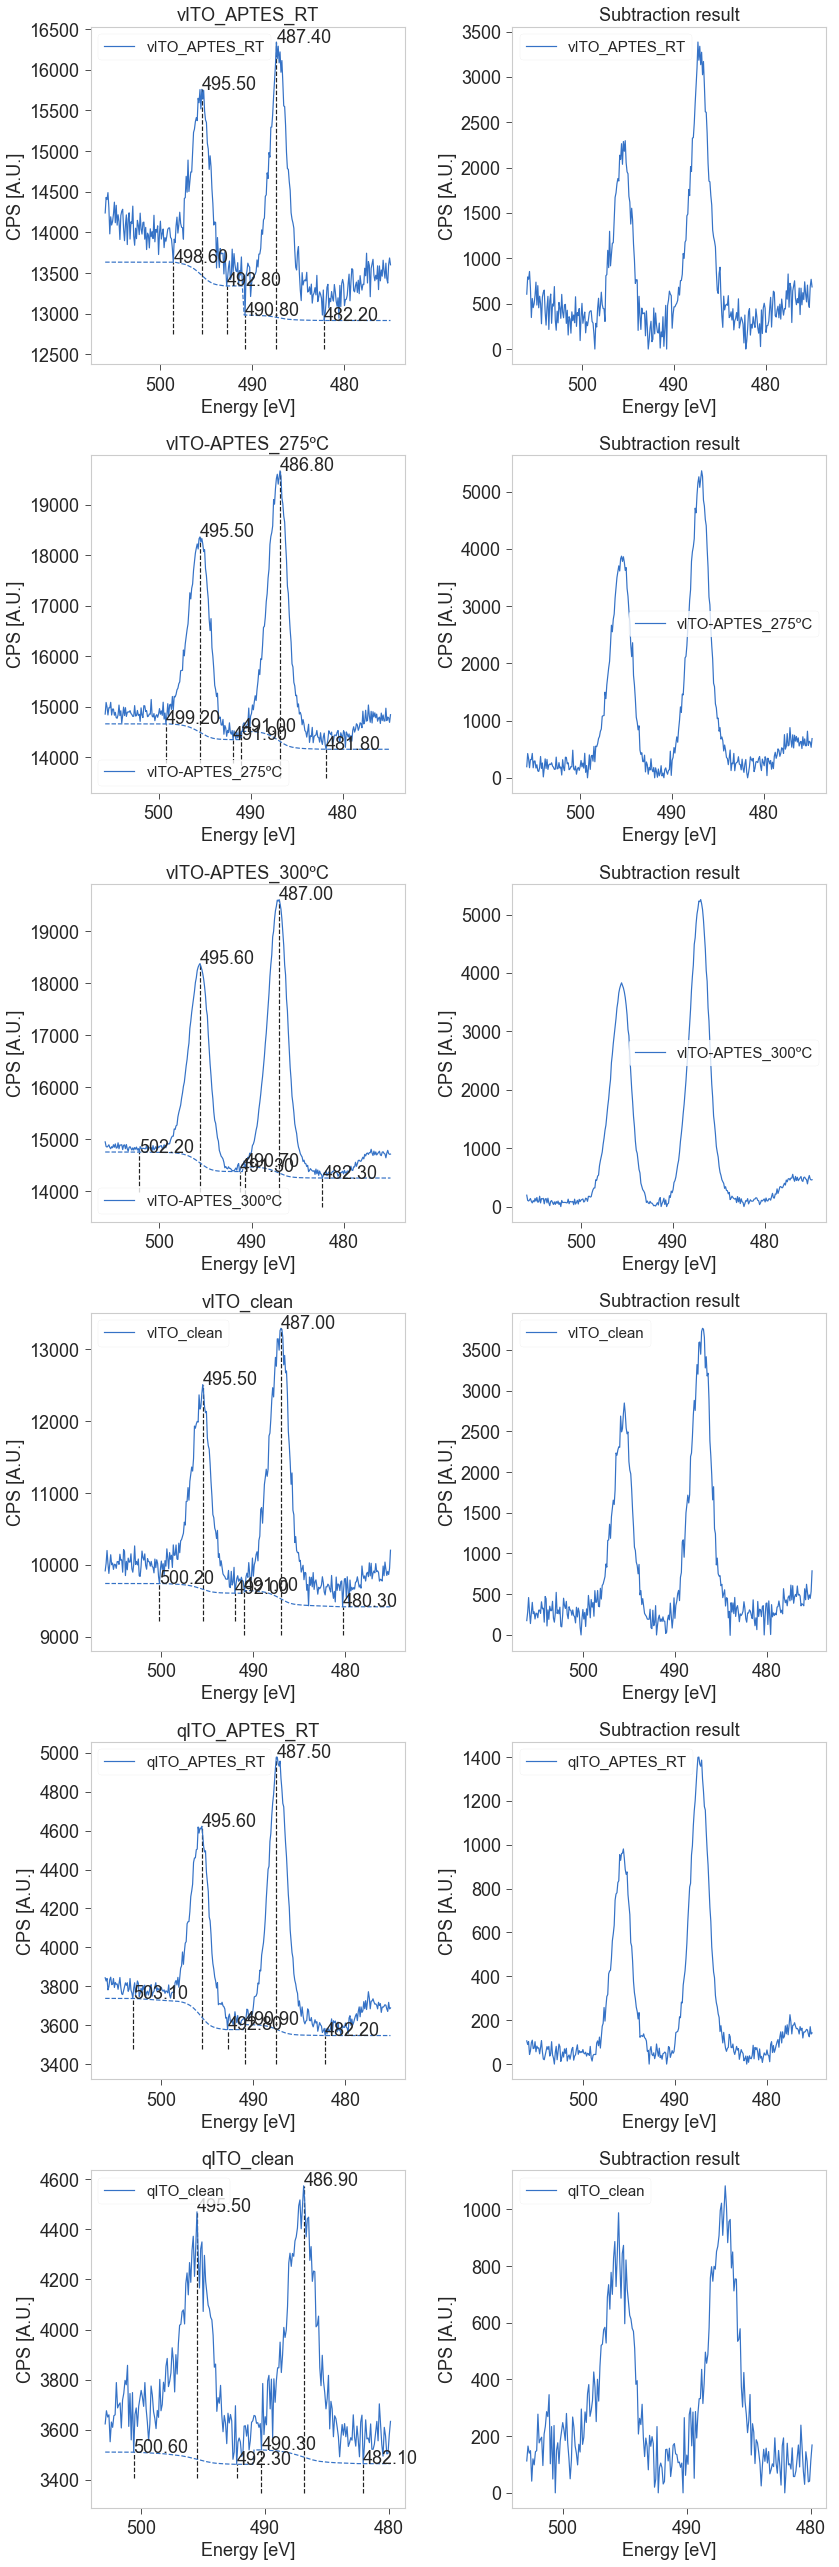

In [211]:
region = 'Sn3d'
bg_exps = region_2bg_subtract(bg_exps, region, xlim=491)

### C, N, O and Br

KeyError on  'Br3p'
KeyError on  'Br3p'
KeyError on  'Br3p'
Max iterations exceeded, subtract ALS baseline


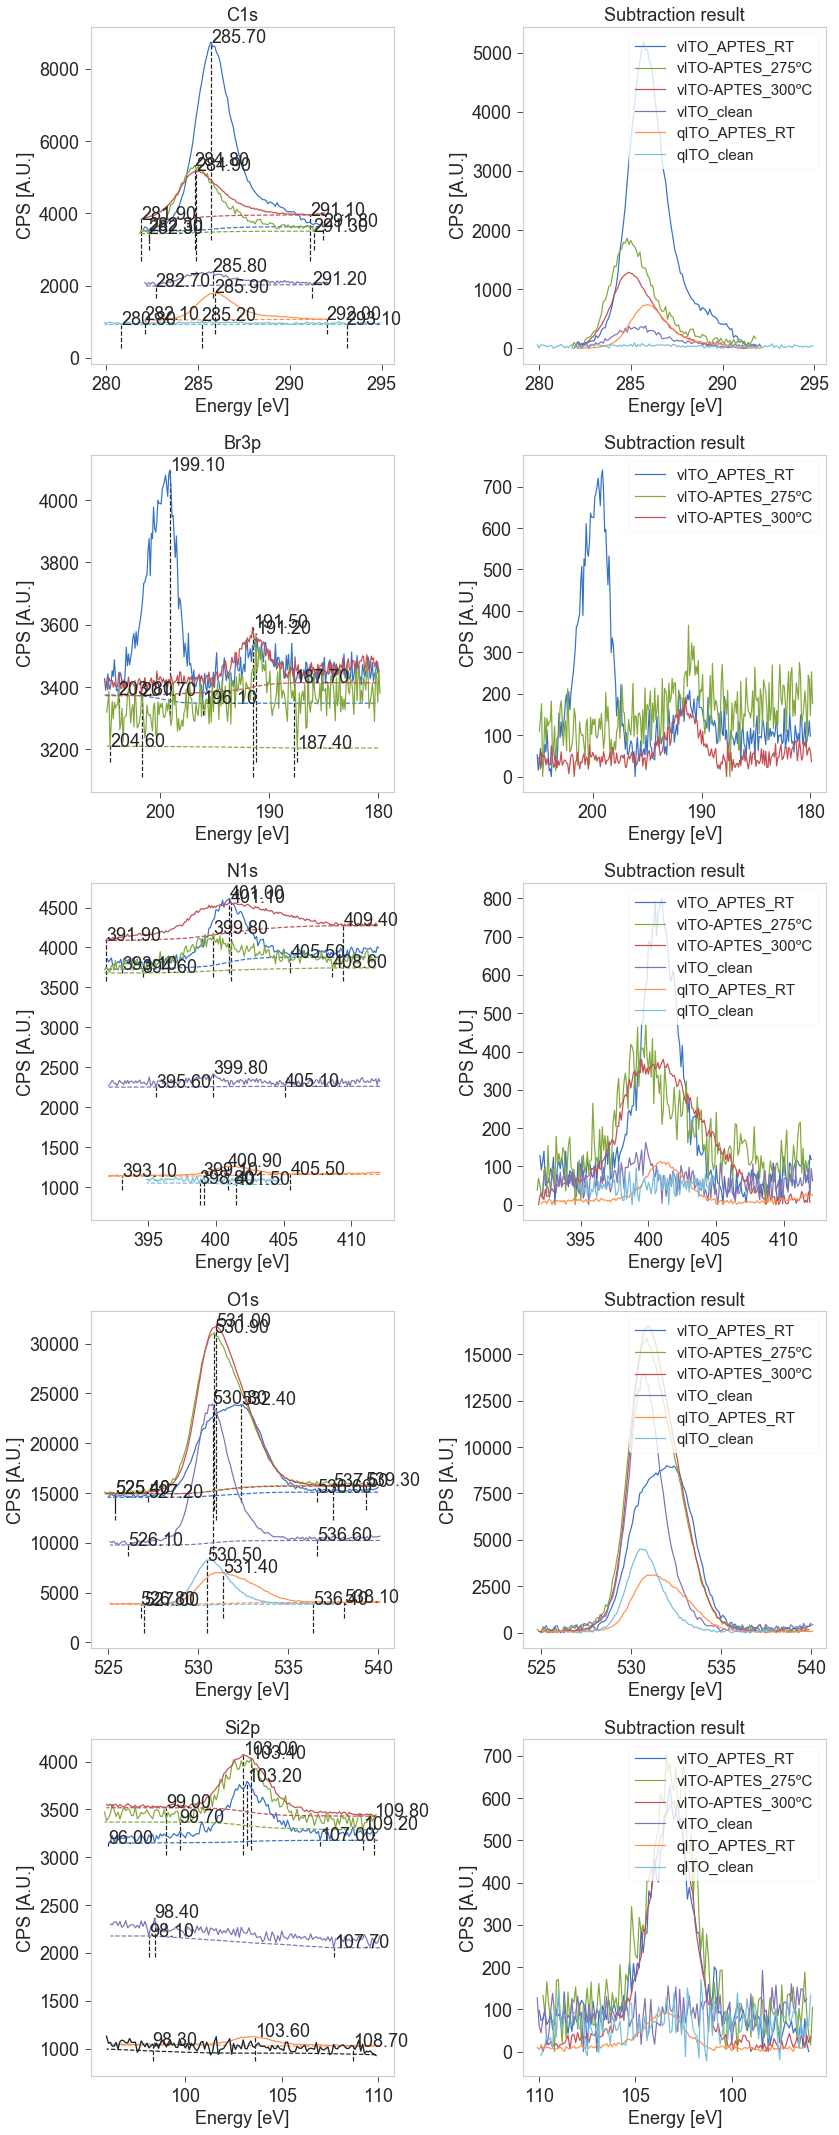

In [212]:
regions = ['C1s', 'Br3p', 'N1s', 'O1s', 'Si2p']
bg_exps = bulk_bg_subtract(bg_exps, regions)

## Plot spectra 

In [41]:
regions = experiments[0].dfx.columns.levels[0].values
regions

array(['Br3p', 'C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f3be3c8>,
      dtype=object)

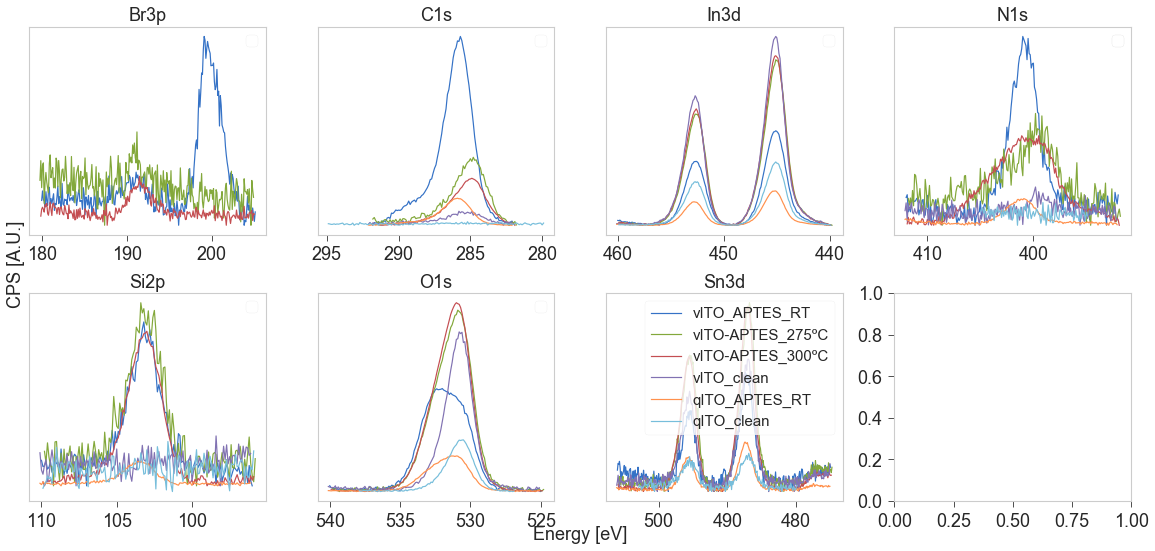

In [213]:
regions = ['Br3p', 'C1s', 'In3d', 'N1s', 'Si2p', 'O1s', 'Sn3d']
plot_xp_regions(bg_exps, regions, ncols=4)

## Scale Plasma experiment (considered clean ref.) to annealing 300 ºC (cleanest in group)

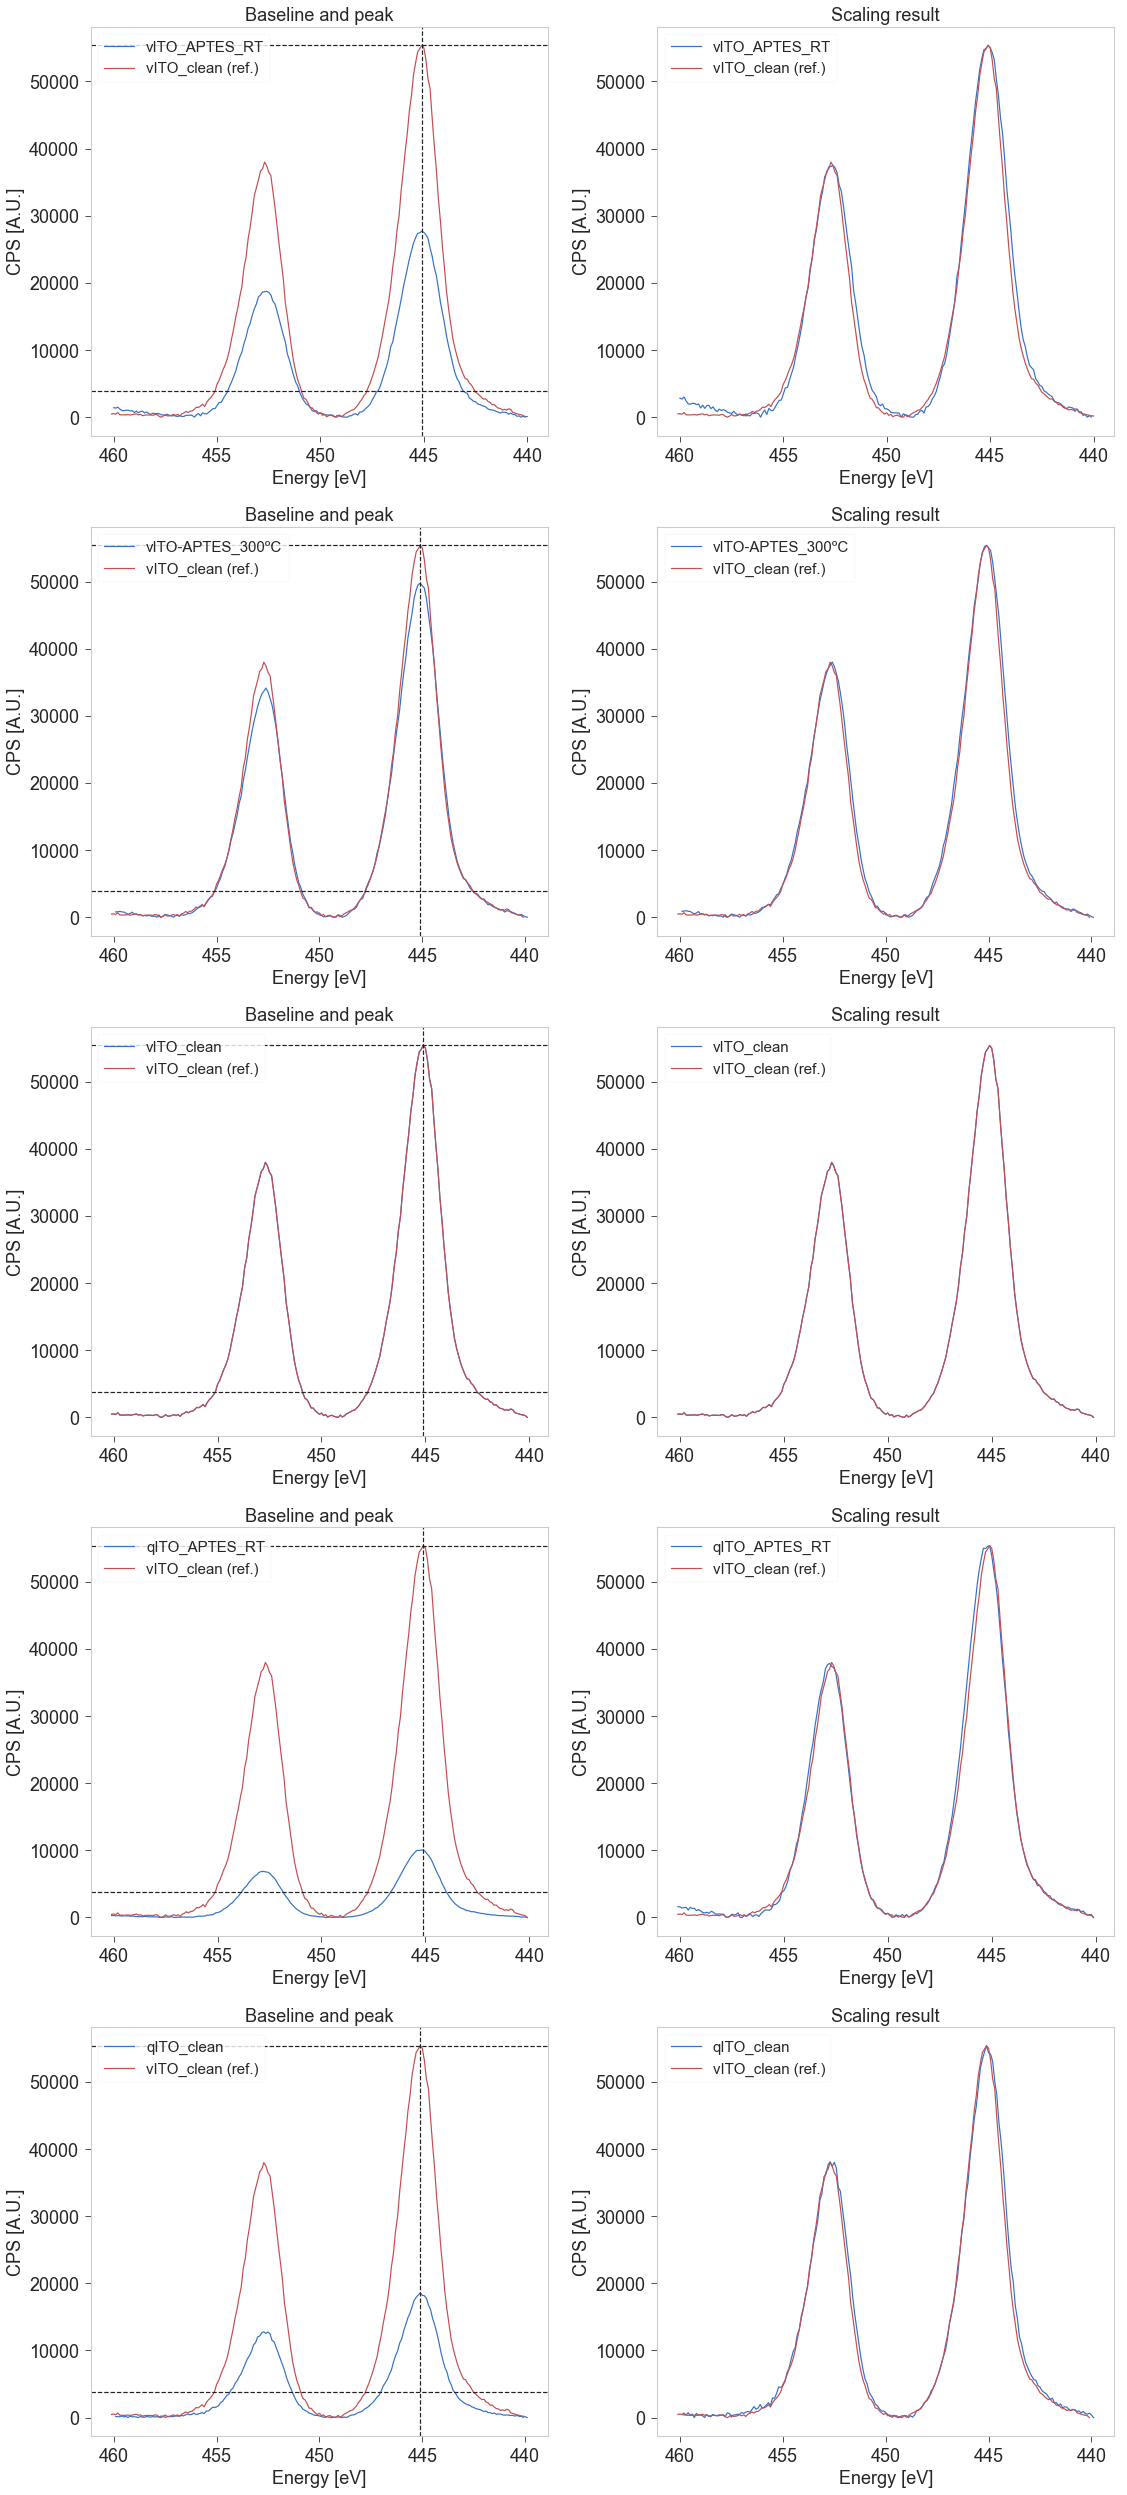

In [103]:
scaled_exps = scale_and_plot_spectra(bg_exps, indRef=2, region='In3d', )

## Store processed experiments

In [104]:
xp.__dict__.keys()

dict_keys(['path', 'delimiters', 'name', 'label', 'date', 'other_meta', 'dfx', 'area', 'fit', 'color', 'ls'])

In [106]:
for xp in scaled_exps:
    xp.fit = {}
    xp.area = {}
for xp in bg_exps:
    xp.fit = {}
    xp.area = {}

In [107]:
[xp.name for xp in bg_exps]

['vITO_APTES_RT',
 'vITO-APTES_300ºC',
 'vITO_clean',
 'qITO_APTES_RT',
 'qITO_clean']

In [109]:
for xpu, xps in zip(bg_exps[:2], scaled_exps[:2]):
    filepath, filename = os.path.split(xpu.path)
    filename = os.path.splitext(filename)[0]
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print('Stored ', newpath + filename)
    print(filename.replace('Annealing', xpu.name))
    write_processed_xp(newpath + filename.replace('Annealing', xpu.name) + '.uxy', xpu)
    write_processed_xp(newpath + filename.replace('Annealing', xps.name) + '.sxy', xps)    
    
for xpu, xps in zip(bg_exps[2:], scaled_exps[2:]):
    filepath, filename = os.path.split(xpu.path)
    filename = os.path.splitext(filename)[0]
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
    print('Stored ', newpath + filename)
    write_processed_xp(newpath + filename + '.uxy', xpu)
    write_processed_xp(newpath + filename + '.sxy', xps)

20201203_ITO_DEA_ZTF594_PA1_vITO_APTES_RT
20201203_ITO_DEA_ZTF594_PA1_vITO-APTES_300ºC
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_DEA/Zoraida_Hank/proc/20201124_ITO_clean
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_APTES/2021_04_27_qITO/proc/20210427_ITO_APTES_thin
Stored  /Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_28_qITO/proc/20210428_3-qITO_clean


# Processed data

## Ploting regions

In [552]:
files = ['/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/proc/20201203_ITO_DEA_ZTF594_PA1_vITO_APTES_RT.uxy',
         '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/proc/20201203_ITO_DEA_ZTF594_PA1_vITO-APTES_300ºC.uxy',
         '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/Zoraida_Hank/proc/20201124_ITO_clean.uxy',
         '/Users/pabloherrero/sabat/xps_spectra/ITO_APTES/2021_04_27_qITO/proc/20210427_ITO_APTES_thin.uxy',
         '/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_28_qITO/proc/20210428_3-qITO_clean.uxy']

paptes = [read_processed_xp(f) for f in files]

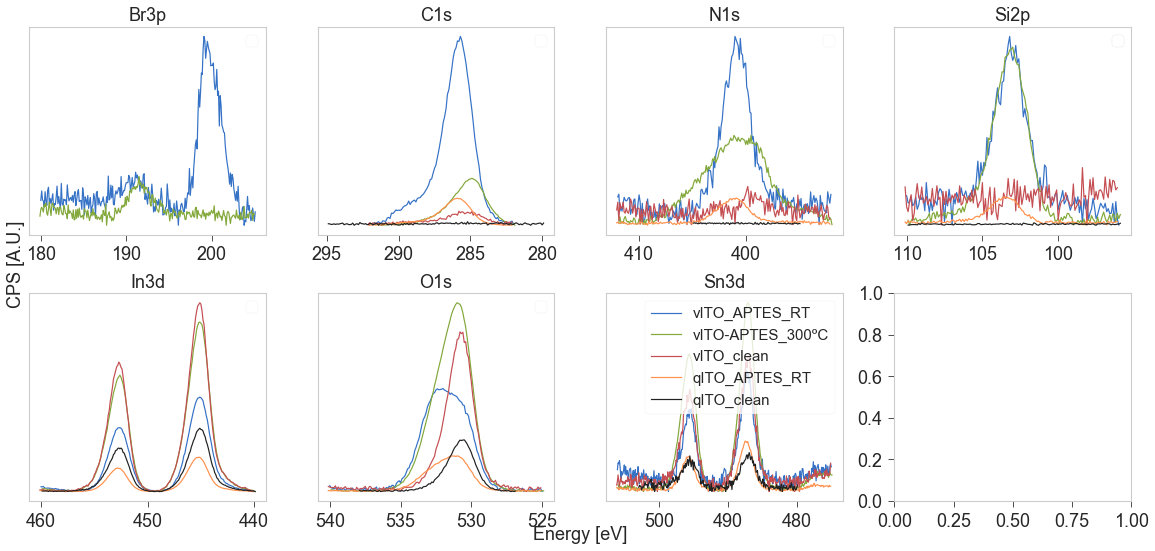

In [553]:
regions = ['Br3p', 'C1s', 'N1s', 'Si2p', 'In3d', 'O1s', 'Sn3d',]

plot_xp_regions(paptes, regions, ncols=4);

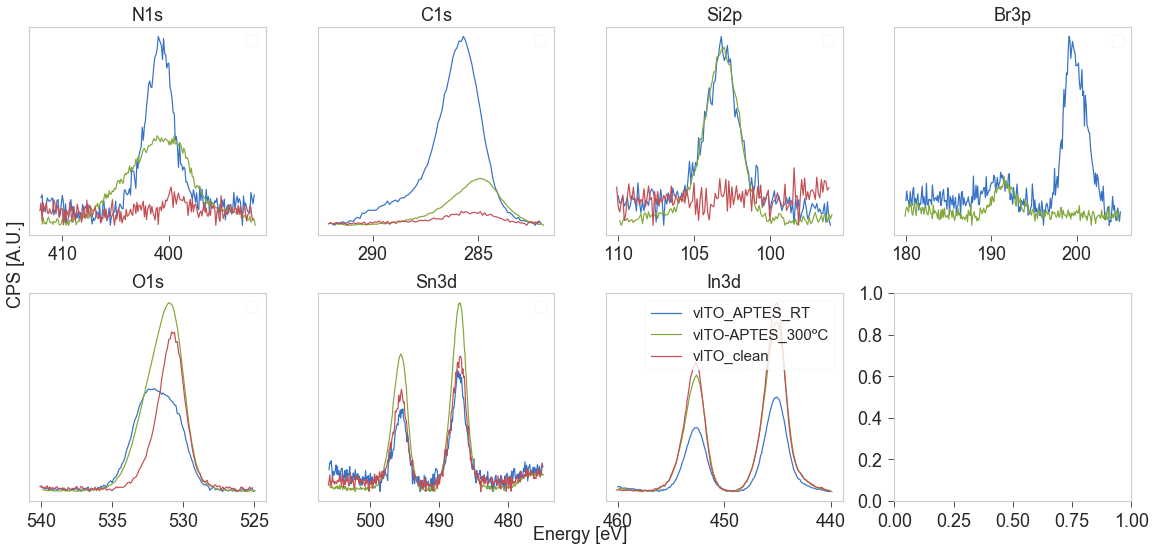

In [223]:
regions = ['N1s', 'C1s', 'Si2p', 'Br3p', 'O1s', 'Sn3d', 'In3d']

plot_xp_regions(paptes[:3], regions, ncols=4);

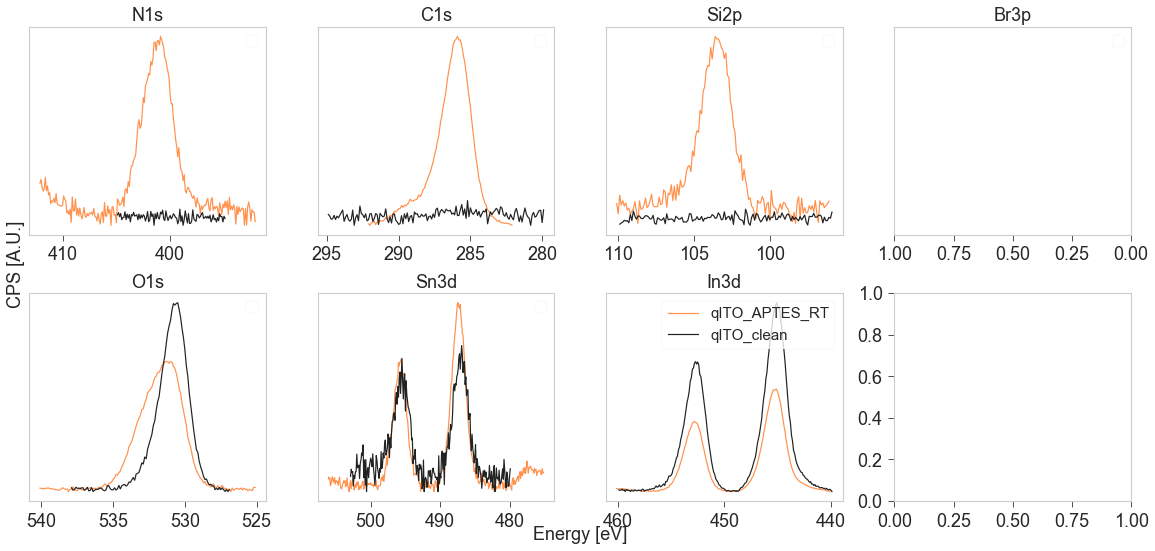

In [226]:
regions = ['N1s', 'C1s', 'Si2p', 'Br3p', 'O1s', 'Sn3d', 'In3d']
paptes[3].color = 'y'
paptes[4].color = 'k'
plot_xp_regions(paptes[3:], regions, ncols=4);

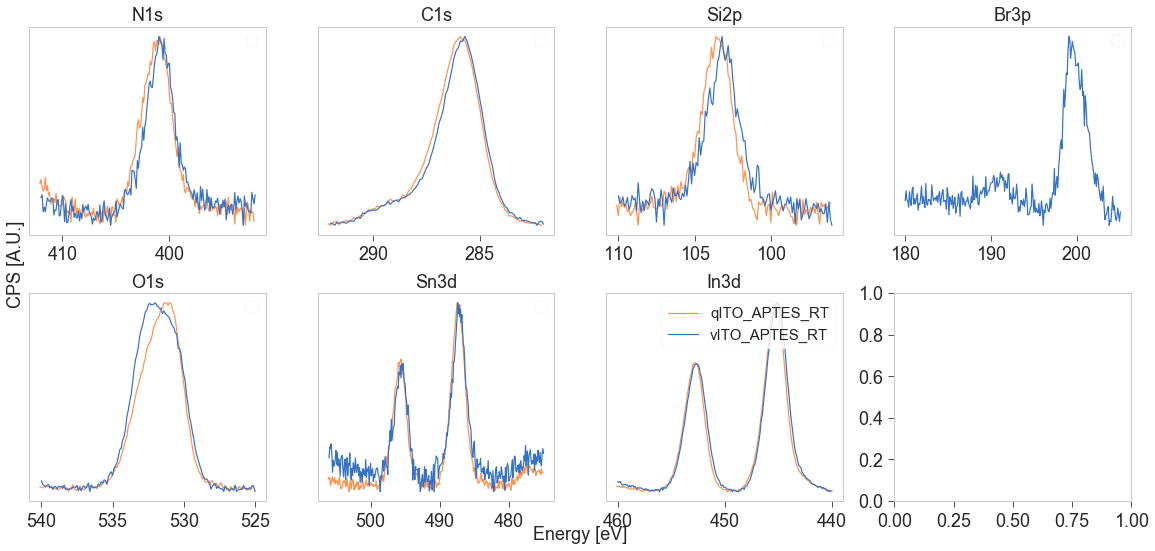

In [229]:
regions = ['N1s', 'C1s', 'Si2p', 'Br3p', 'O1s', 'Sn3d', 'In3d']
paptes[0].color = 'b'
plot_xp_regions([normalise_dfx(paptes[3]), normalise_dfx(paptes[0])], regions, ncols=4);

In [289]:
for xp in paptes:
    print(xp.dfx.columns.levels[0])

Index(['Br3p', 'C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d'], dtype='object', name='range')
Index(['Br3p', 'C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d'], dtype='object', name='range')
Index(['Ba3d', 'C1s', 'Cl2p', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d',
       'overview'],
      dtype='object', name='range')
Index(['C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d', 'overview'], dtype='object', name='range')
Index(['C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d', 'overview'], dtype='object', name='range')


### Check no Br 3p is present in the last sample

[(0, 10000.0), (210, 180)]

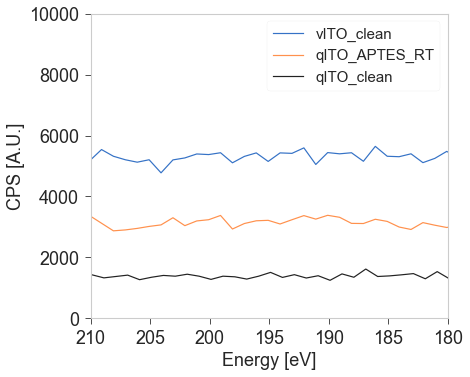

In [291]:
for xp in paptes[2:]:
    plot_region(xp, 'overview')
plt.gca().set(xlim=(210, 180), ylim=(0, 1e4))

## Stoichiometry

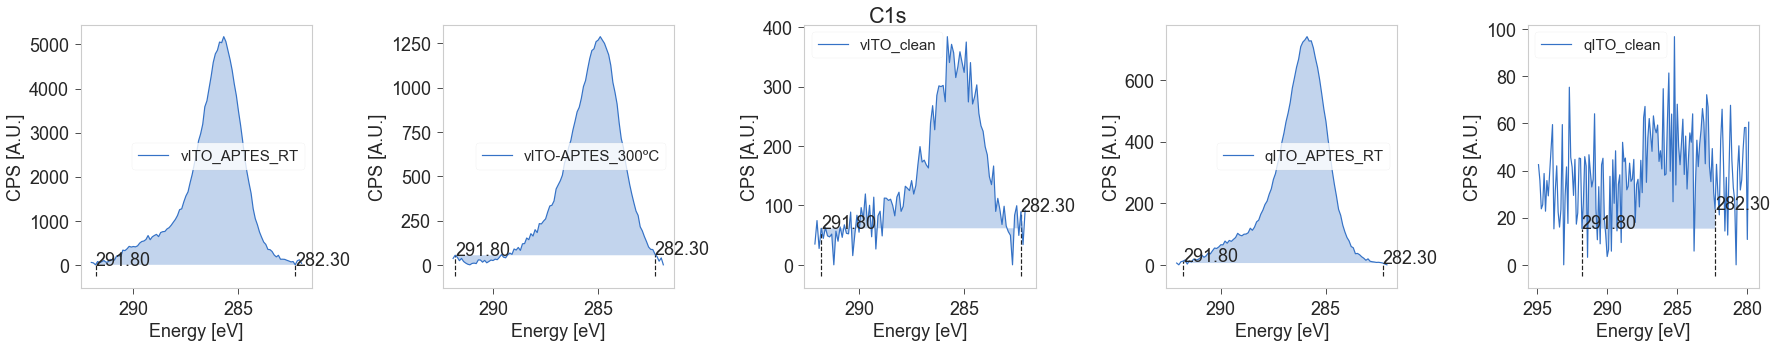

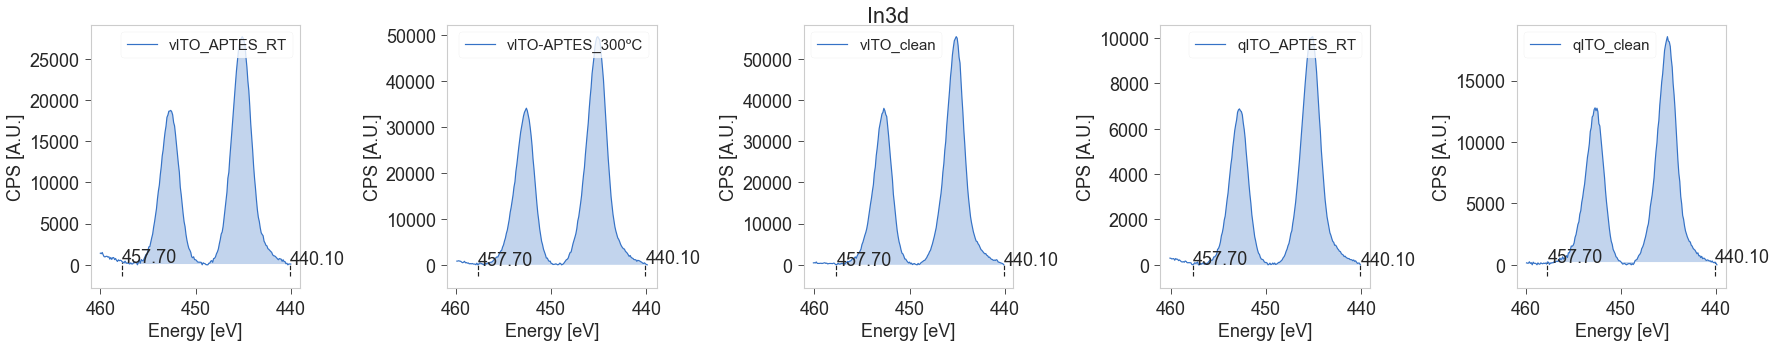

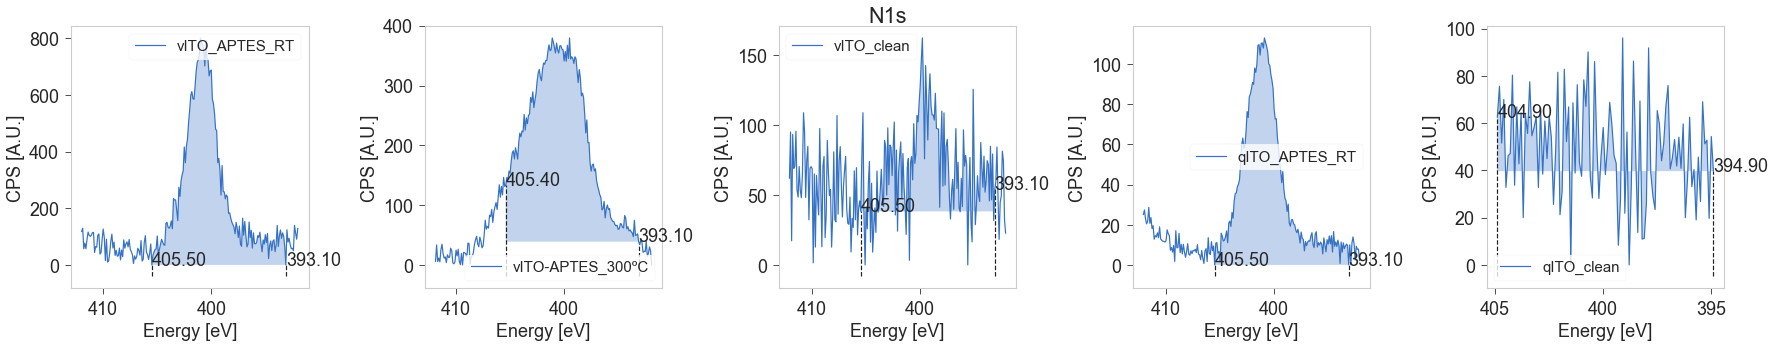

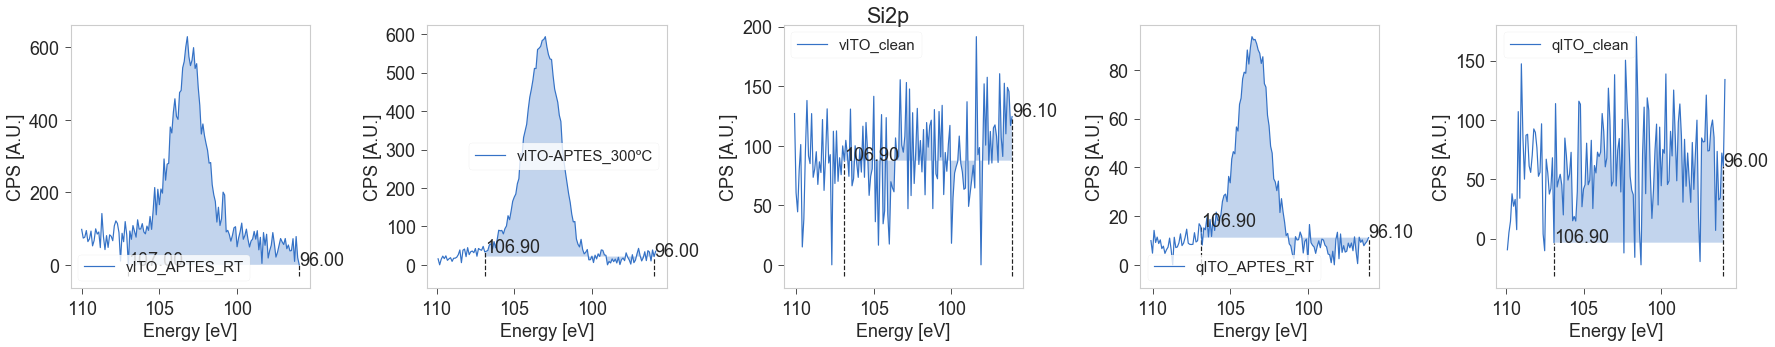

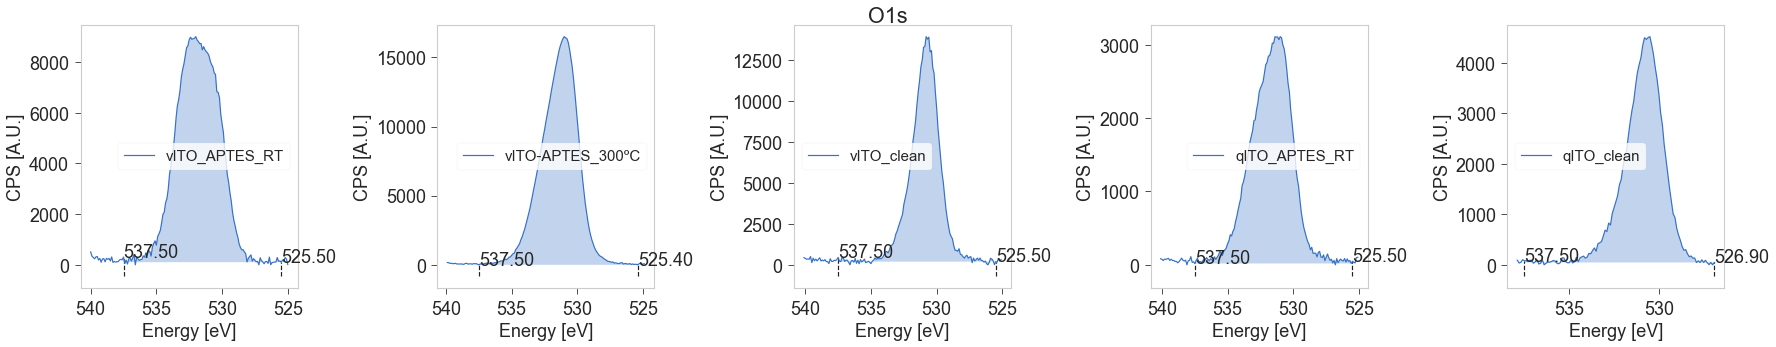

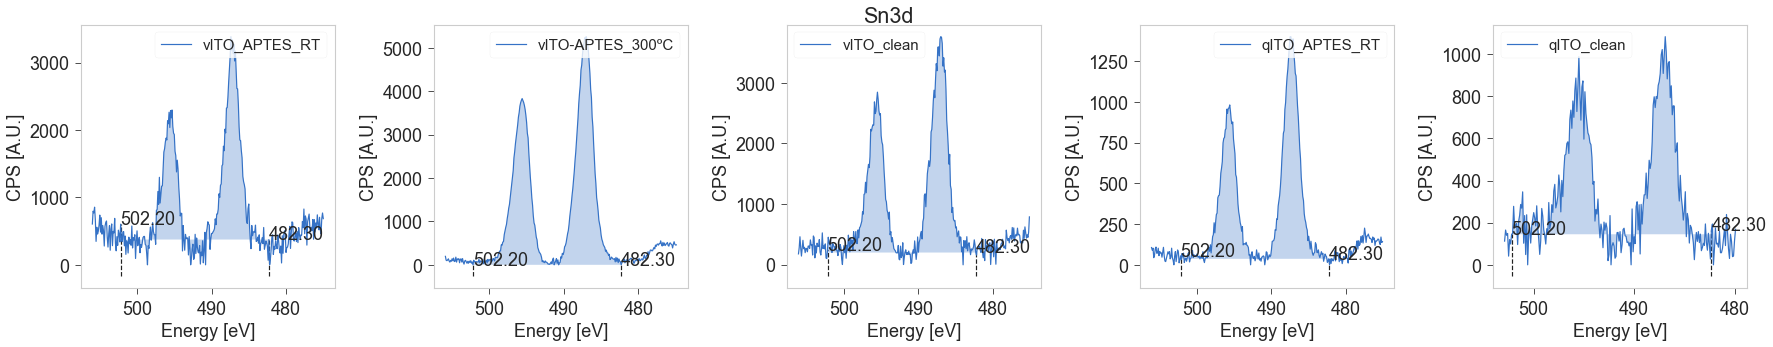

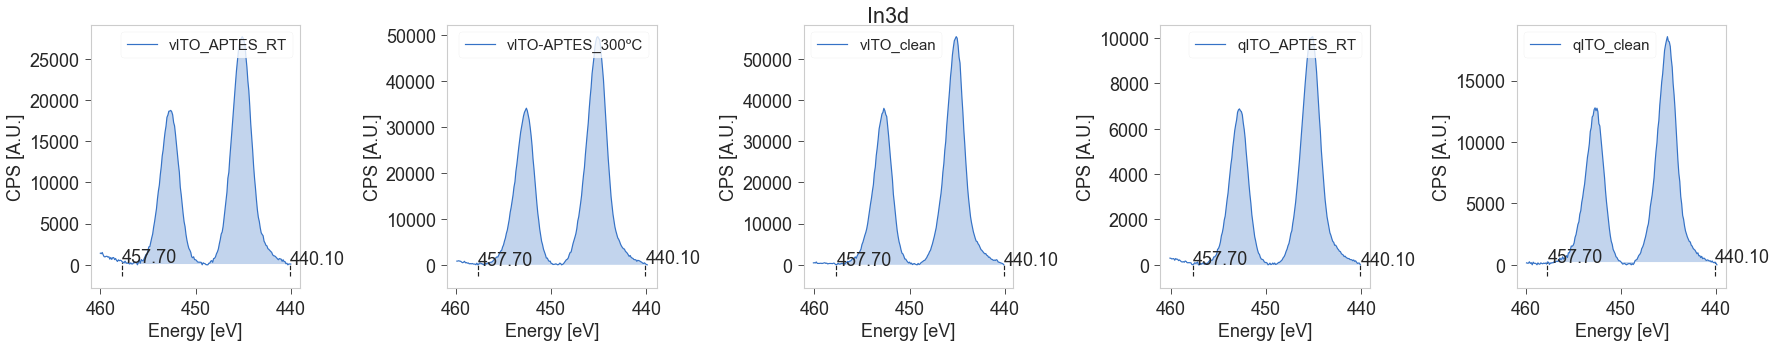

In [115]:
for r in regions:
    integrateRegions(paptes, r, asf)

[3478.467261350552,
 2919.8699122680046,
 1108.9035426960836,
 499.4561800346552,
 489.20933951109754]

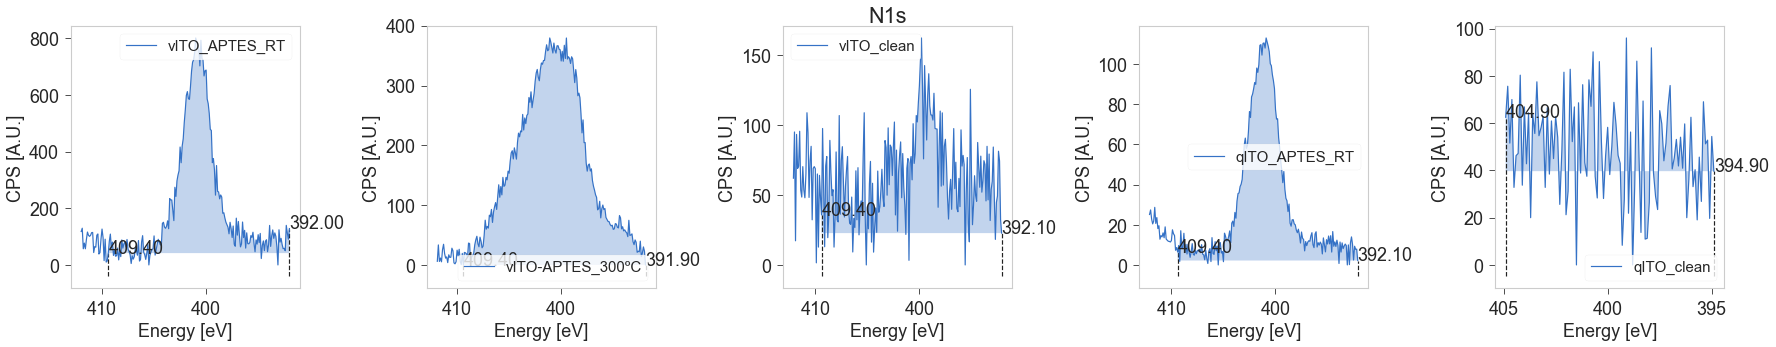

In [116]:
integrateRegions(paptes, 'N1s', asf, indRef=1)

In [146]:
num, denom = (('C1s', 'N1s', 'C1s', 'N1s'), ('N1s', 'Si2p', 'Si2p', 'O1s'))

make_stoichometry_table(paptes, num, denom)

Experiment	C/N	N/Si	C/Si	N/O	
vITO_APTES_RT	6.52 	 1.19 	 7.76 	 0.14 	 
vITO-APTES_300ºC	2.15 	 1.16 	 2.50 	 0.08 	 
vITO_clean	2.08 	 0.78 	 1.63 	 0.05 	 
qITO_APTES_RT	6.70 	 1.18 	 7.93 	 0.06 	 
qITO_clean	1.32 	 0.48 	 0.64 	 0.06 	 


# Coverage

In [554]:
from invisible_cities.core.system_of_units import nm
inds = [[0, 1, 2], [3, 4]]
arrange_coverages(paptes, inds, r_ml = 0.8 * nm, region = 'In3d', mfp = 2.88 * nm, takeoff=10)

matrix([[2.27117733e+00, 2.64776539e-02],
        [2.14382892e-01, 1.34803740e-03],
        [2.24584933e+00, 4.46373226e-02]])

In [556]:
def plot_coverages(experiments, label='__nolabel__'):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name.replace('_', ' ') )
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=layers, xerr=dlayers, y=names, fmt='o', markersize=10, label=label)
    ax.set_xlabel('Layers')
    ax.legend()
    return ax

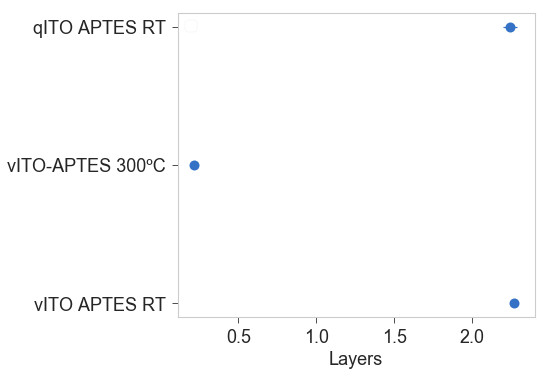

In [558]:
ax = plot_coverages(paptes)
# plt.gca().set(xlabel='Thickness [nm]')

In [297]:
paptes[2].color = 'r'

[[], (-928.4438096662509, 23396.784003589524), Text(0, 0.5, '')]

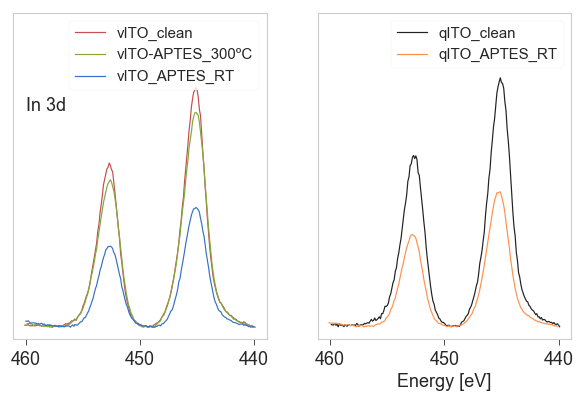

In [299]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
r = 'In3d'
for xp in paptes[2::-1]:
    plot_region(xp, r, ax=ax[0])
ax[0].invert_xaxis()
ax[0].legend()
ax[0].text(s='In 3d', x=460, y=5e4)
ylim = ax[0].get_ylim()
ax[0].set(yticks=[], ylabel='', ylim=(ylim[0], ylim[1]*1.25))
for xp in paptes[-1:2:-1]:
    plot_region(xp, r, ax=ax[1])
ylim = ax[1].get_ylim()
ax[1].set(yticks=[], ylabel='', ylim=(ylim[0], ylim[1]*1.2))

# Fits

Modify user pars
Modify user pars
Modify user pars


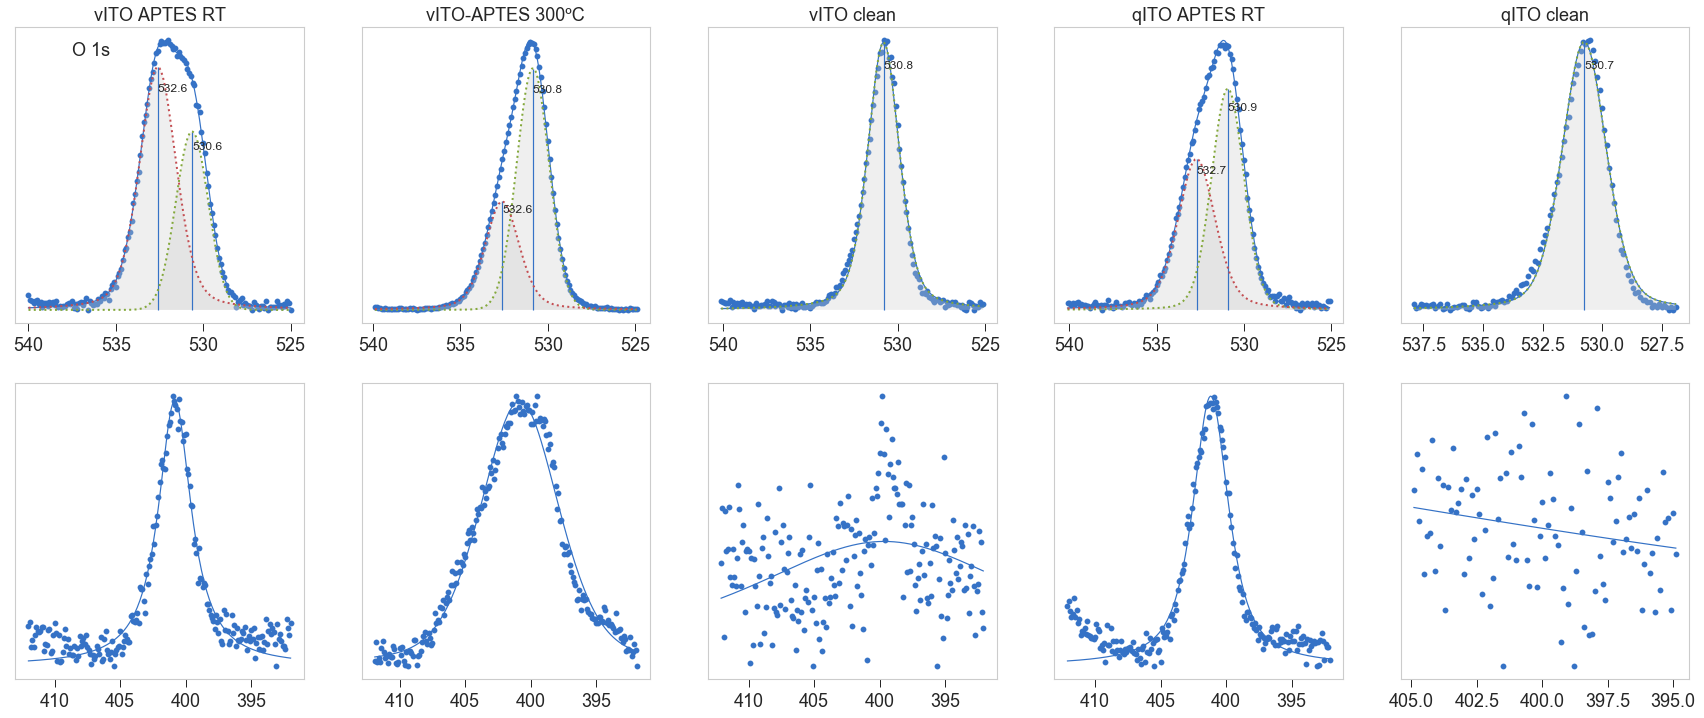

In [178]:
fig, ax = plt.subplots(2, 5, sharex=False, figsize=(30, 12), )

r = 'O1s'
for i, xp in enumerate(paptes):
    Fn = XPFit(xp, region = r)
    if (i == 2) or (i == 4):
        Fn.voigt()
    else:
        Fn.preset_pars('v1_sigma', 1.0962359109390833)
        Fn.double_voigt(sepPt=531.5)
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], )
#                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
ax[0][0].text(s='O 1s', x=537.5, y=ax[0][0].get_ylim()[1]*0.9)

r = 'N1s'
# li = plot_fit_result(paptes[4], r, fitRes=subml[4].fit[r], ax=ax[1][3], flag_fill=True, plot_comps=False)
# lim = li.get_ylim()
ax[1][3].cla()
for i,xp in enumerate(paptes):
    Fn = XPFit(xp, region = r)
#     Fn.voigt()
    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], flag_fill=True, plot_comps=False)
    ax[1][i].set(xlabel='', ylabel='', yticks=[])#, ylim=lim)
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major',)
# ax[1][0].text(s='N 1s', x=99, y=lim[1]*0.9)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in subml[:0:-1]], ncol=len(selection),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

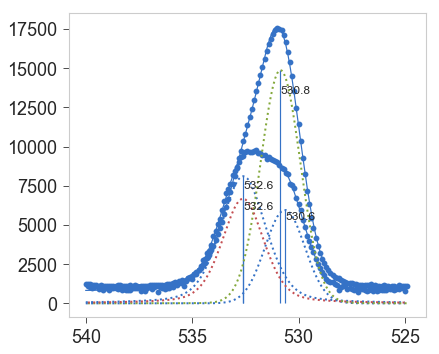

In [230]:
r = 'O1s'
# plot_fit_result(paptes[2], r, paptes[2].fit[r])
plot_fit_result(paptes[0], r, paptes[0].fit[r])
plot_fit_result(paptes[1], r, paptes[1].fit[r])
plt.gca().invert_xaxis()

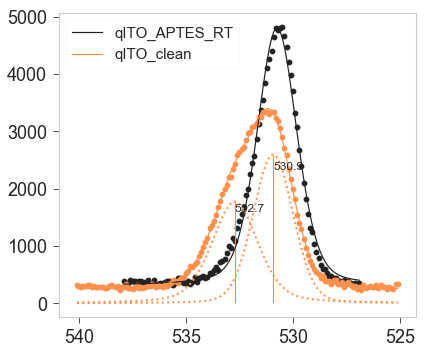

In [243]:
r = 'O1s'
plot_fit_result(paptes[4], r, paptes[4].fit[r], plot_comps=False)
li = plot_fit_result(paptes[3], r, paptes[3].fit[r])
plt.gca().invert_xaxis()
plt.gca().legend(list(li.get_lines()), [xp.name for xp in paptes[3:]])

### Recompute stoichiometry with extra O 1s component

In [177]:
paptes[4].fit[r].best_values['v1_sigma']

1.0962359109390833

In [181]:
for xp in paptes[:2]+[paptes[3]]:
    xp.area['O1s_c'] = xp.area['O1s'] * xp.area['O1s_v2_']

In [195]:
make_stoichometry_table(paptes[:2]+[paptes[3]], num=('O1s_c', 'O1s_c', 'O1s_c'), denom=('Si2p', 'N1s', 'C1s'))

Experiment	O/Si	O/N	O/C	
vITO_APTES_RT	3.89 	 3.26 	 0.50 	 
vITO-APTES_300ºC	3.46 	 2.97 	 1.38 	 
qITO_APTES_RT	6.00 	 5.07 	 0.76 	 


In [202]:
print('\t\t O/Si \t O/N \t O/C')
print('Nominal APTES \t 3 \t 3 \t 0.33')
print('Silane- APTES \t 3 \t 3 \t 1')

		 O/Si 	 O/N 	 O/C
Nominal APTES 	 3 	 3 	 0.33
Silane- APTES 	 3 	 3 	 1


In [186]:
num, denom = (('C1s', 'N1s', 'C1s'), ('N1s', 'Si2p', 'Si2p'))

make_stoichometry_table(paptes[:2]+[paptes[3]], num, denom)

Experiment	C/N	N/Si	C/Si	
vITO_APTES_RT	6.52 	 1.19 	 7.76 	 
vITO-APTES_300ºC	2.15 	 1.16 	 2.50 	 
qITO_APTES_RT	6.70 	 1.18 	 7.93 	 


In [198]:
print('\t\t C/N \t N/Si \t C/Si')
print('Nominal APTES \t 9 \t 1 \t 9')
print('Silane- APTES \t 3 \t 1 \t 3')

		 C/N 	 N/Si 	 C/Si
Nominal APTES 	 9 	 1 	 9
Sinalize APTES 	 3 	 1 	 3


In [197]:
print('APTES: C 9 H 23 NO3 Si')
print('Sinalized APTES: C 3 H 23 NO3 Si')

APTES: C 9 H 23 NO3 Si
Sinalized APTES: C 3 H 23 NO3 Si


In [184]:
make_stoichometry_table(paptes[:2]+[paptes[3]], num=('Si2p', 'N1s', 'C1s'), denom=('O1s', 'O1s', 'O1s'))

Experiment	Si/O	N/O	C/O	
vITO_APTES_RT	0.16 	 0.19 	 1.26 	 
vITO-APTES_300ºC	0.10 	 0.12 	 0.25 	 
qITO_APTES_RT	0.08 	 0.09 	 0.60 	 


## Fits C 1s, Si 2p

In [251]:
paptes[1].color = 'g'

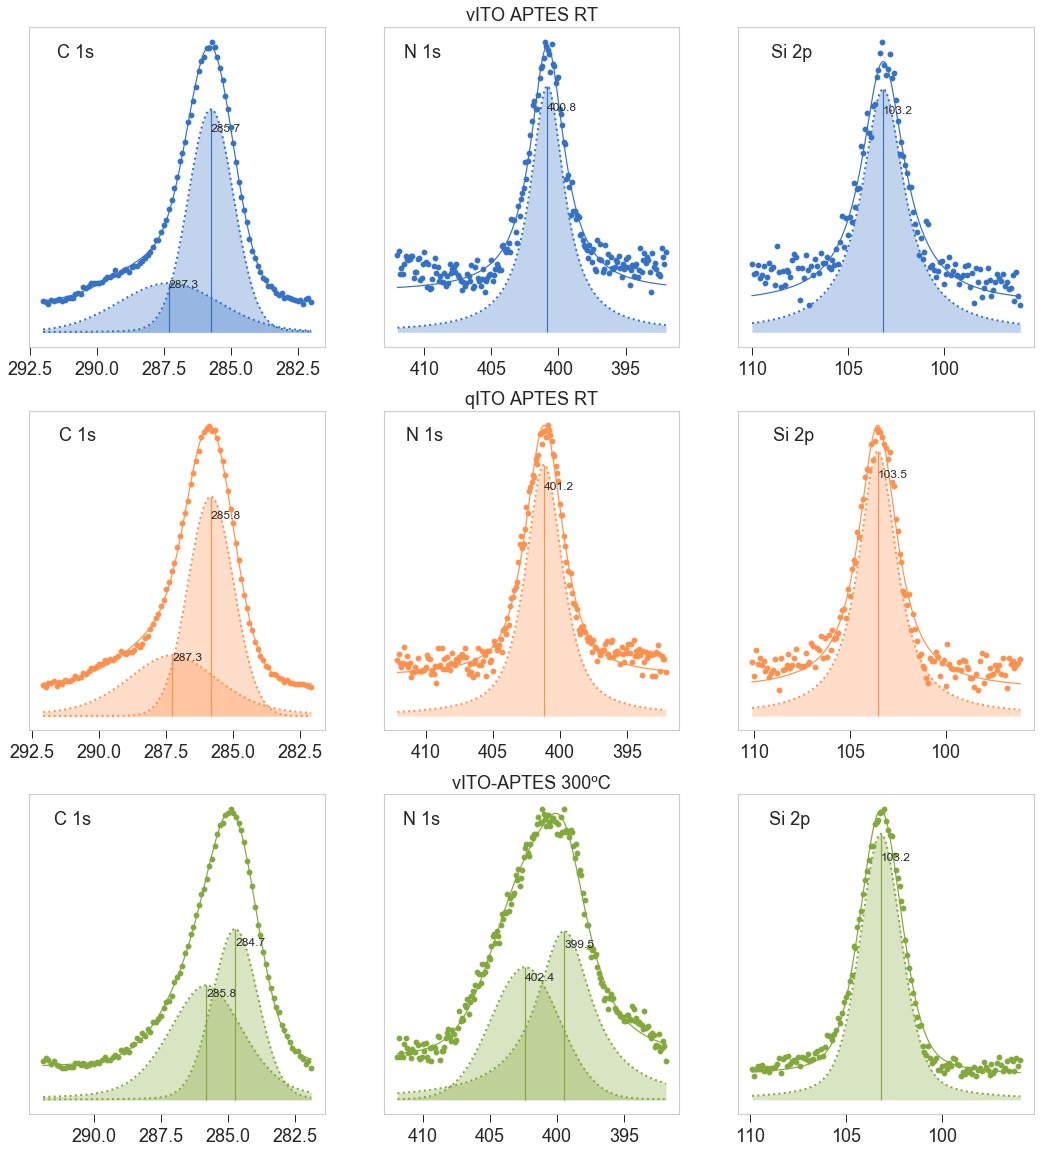

In [315]:
fig, ax = plt.subplots(3, 3, sharex=False, figsize=(18, 20), )

selection = [paptes[0], paptes[3], paptes[1]]
r = 'C1s'
for i, xp in enumerate(selection):
    Fn = XPFit(xp, region = r)
#     Fn.preset_pars('v1_sigma', 1.0)
#     Fn.double_voigt(sepPt=286)
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[i][0], offset=0.4,
                    flag_fill=True, plot_comps=True)
#     ax[i][0].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], )
    ax[i][0].set(xlabel='', ylabel='', yticks=[], )
    
    ax[i][0].invert_xaxis()
    ax[i][0].tick_params('both', length=8, width=1, which='major')
    ax[i][0].text(s='C 1s', x=291.5, y=ax[i][0].get_ylim()[1]*0.9)

offset = 0.7

r = 'N1s'
for i, xp in enumerate(selection):
    Fn = XPFit(xp, region = r)
    if i == 2: offset = 0.4
#         Fn.double_voigt(sepPt=401)
#     else: Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[i][1], offset=offset,
                    flag_fill=True, plot_comps=True)
#     ax[i][2].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], )
    ax[i][1].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], )

    ax[i][1].invert_xaxis()
    ax[i][1].tick_params('both', length=8, width=1, which='major')
    ax[i][1].text(s='N 1s', x=411.5, y=ax[i][1].get_ylim()[1]*0.9)
    
r = 'Si2p'
for i,xp in enumerate(selection):
#     Fn = XPFit(xp, region = r)
#     Fn.voigt()
    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[i][2], offset=offset,
                         flag_fill=True, plot_comps=True)
    ax[i][2].set(xlabel='', ylabel='', yticks=[])#, ylim=lim)
    ax[i][2].set(xlabel='', ylabel='', yticks=[], )
    
    ax[i][2].invert_xaxis()
    ax[i][2].tick_params('both', length=8, width=1, which='major',)
    ax[i][2].text(s='Si 2p', x=109, y=ax[i][2].get_ylim()[1]*0.9)


In [319]:
for xp in selection:
    print(xp.area['C1s_v1_'],xp.area['C1s_v2_'])

0.675378128162358 0.3246218718376421
0.6363656060227373 0.3636343939772626
0.47021926389397606 0.5297807361060239


0.675378128162358
0.6363656060227373
0.47021926389397606


# Store results

In [320]:
for xp in paptes:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/proc/20201203_ITO_DEA_ZTF594_PA1_vITO_APTES_RT.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/proc/20201203_ITO_DEA_ZTF594_PA1_vITO-APTES_300ºC.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_DEA/Zoraida_Hank/proc/20201124_ITO_clean.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_APTES/2021_04_27_qITO/proc/20210427_ITO_APTES_thin.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/2021_04_28_qITO/proc/20210428_3-qITO_clean.uxy.ft successful


# Dev: auto-search for number of peaks

In [328]:
mod

<lmfit.Model: (Model(pvoigt, prefix='v1_') + Model(pvoigt, prefix='v2_'))>

In [496]:
def guess_pars(mod, x, y, prefix):
    pars = mod.make_params()
    guess = mod.guess(y, x)

    pars[prefix+'center'].set(value=guess[prefix+'center'].value)
    pars[prefix+'amplitude'].set(value=abs(guess[prefix+'amplitude'].value), min=0)
    pars[prefix+'fraction'].set(value=0.7, vary=False)
    return pars

def split_component(xs:list, ys:list, largest_comp:int):
    sepPt = np.average(xs[largest_comp])
    xsplit = xs[largest_comp]
    ysplit = ys[largest_comp]
    xl = xsplit[xsplit<sepPt]
    xr = xsplit[xsplit>sepPt]
    yl = ysplit[xsplit<sepPt]
    yr = ysplit[xsplit>sepPt]

    xs.pop(largest_comp)
    xs += [xl, xr]
    ys.pop(largest_comp)
    ys += [yl, yr]
    return xs, ys

def set_mod_pars(ncomps: int, xs: list, ys: list):
    mods = [PseudoVoigtModel(prefix='v'+str(i)+'_') for i in range(ncomps)]
    parsi = []
    mod = mods[0]

    for i,(m, xx, yy) in enumerate(zip(mods, xs, ys)):
        parsi.append(guess_pars(m, xx, yy, prefix='v'+str(i)+'_'))
        if i > 0: mod += m

    pars = mod.make_params()
    for i,p in enumerate(parsi):
        pars.update(p)
    return mod, pars    

In [560]:
def fit_n_voigt(xp: XPS_experiment, region: str, max_comps: int=3, flag_save: bool = False):
    
    chis = []
    x = xp.dfx[region].dropna().energy.values
    y = xp.dfx[region].dropna().counts.values
    xs = [x]
    ys = [y]
    fig, ax = plt.subplots(1, max_comps, figsize=(6*max_comps, 6))

    for ncomps in range( max_comps):
        if ncomps > 0:
            sigmas = np.array([fitv.best_values['v'+str(i)+'_sigma'] for i in range(ncomps)])

            largest_comp = np.argmin(sigmas)
            xs, ys = split_component(xs, ys, largest_comp)

        mod, pars = set_mod_pars(ncomps+1, xs, ys)

        fitv = mod.fit(y, pars, x=x)
        plot_fit_result(xp, region, fitv, ax=ax[ncomps])
        chis.append(fitv.redchi)
        if flag_save: xp.fit[region+'_'+ncomps+'comps'] = fitv
    print('Best chi2 value for %i components' %(np.argmin(chis)+1))
    return chis

0
1
largest_comp =  0
2
largest_comp =  0
3
largest_comp =  1
4
largest_comp =  2


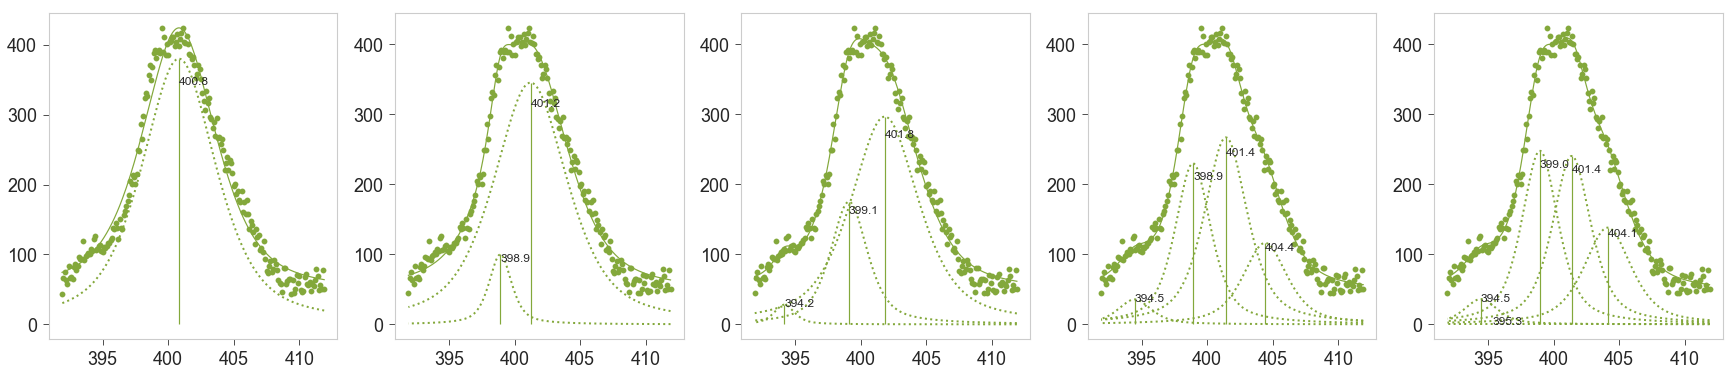

In [532]:
red_chis = fit_n_voigt(paptes[1], 'N1s', max_comps=5)

Best chi2 value for 4 components


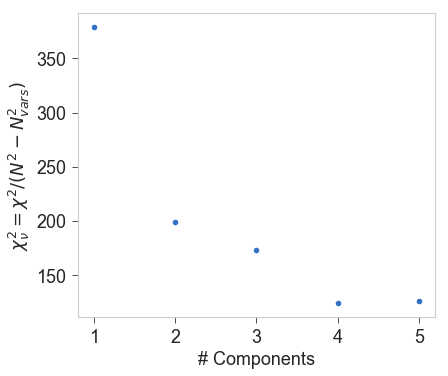

In [548]:
plt.plot(range(1, len(red_chis)+1), red_chis, 'o')

plt.xlabel('# Components')
plt.ylabel('$\\chi_\\nu^2 = \\chi^2 / (N^2 - N^2_{vars})$ ')
print('Best chi2 value for %i components' %(np.argmin(chis)+1))


In [541]:
red_chis

[379.27853409844334,
 198.8437318591692,
 173.52074419514022,
 124.08426940944591,
 126.51457747797734]

Best chi2 value for 3 components


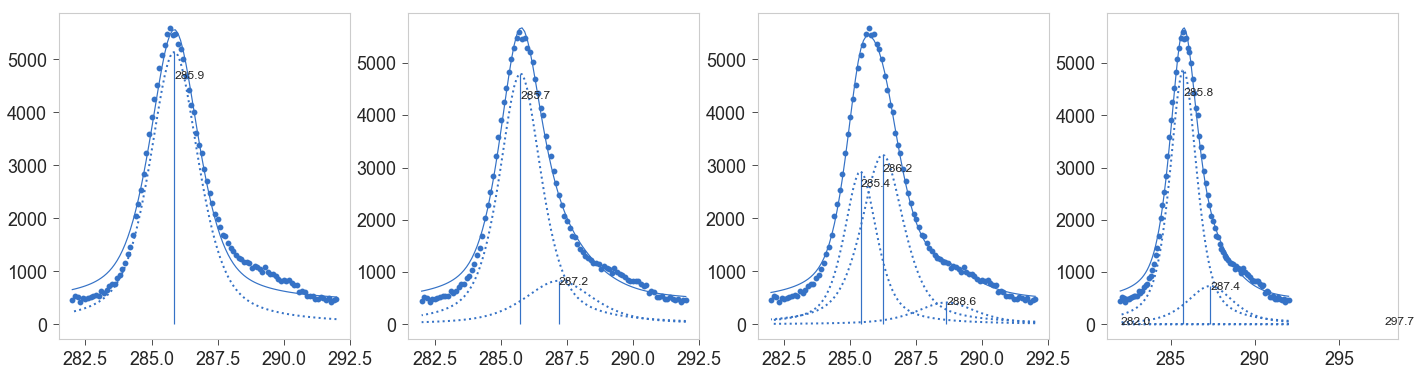

In [561]:
red_chis = fit_n_voigt(paptes[0], 'C1s', max_comps=4)

Best chi2 value for 4 components


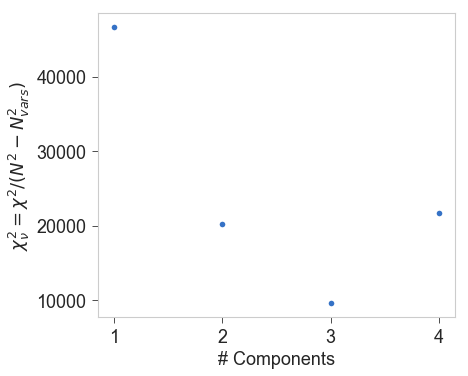

In [562]:
plt.plot(range(1, len(red_chis)+1), red_chis, 'o')

plt.xlabel('# Components')
plt.ylabel('$\\chi_\\nu^2 = \\chi^2 / (N^2 - N^2_{vars})$ ')
print('Best chi2 value for %i components' %(np.argmin(chis)+1))


Best chi2 value for 4 components


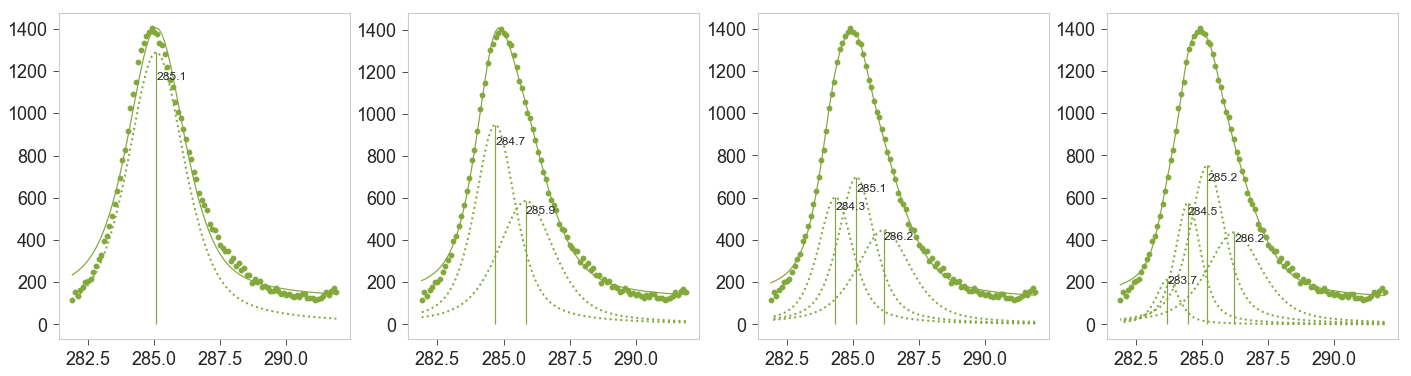

In [563]:
red_chis = fit_n_voigt(paptes[1], 'C1s', max_comps=4)

Best chi2 value for 4 components


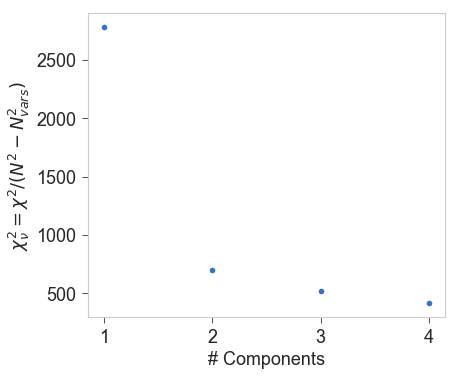

In [564]:
plt.plot(range(1, len(red_chis)+1), red_chis, 'o')

plt.xlabel('# Components')
plt.ylabel('$\\chi_\\nu^2 = \\chi^2 / (N^2 - N^2_{vars})$ ')
print('Best chi2 value for %i components' %(np.argmin(chis)+1))
